# Kiltisbotin kulutusdata

Kiltisbot on Fyysikkokillan kiltistoimikunnan ylläpitämä Telegramin bottirajapintaan pohjautuva multimedia ratkaisu, jonka tarkoitus on helpottaa kiltalaisten elämää. Kiltibotissa on tällä hetkellä integraatiot niin Fiirumille kuin Fyysikkokillan Googlekalenteriinkin. Kiltisbotin alkuperäinen ja tärkein käyttötarkoitus on kiltiksen herkkukaapin piikkimyynnin siirtäminen 2000-luvulle eli paperisesta piikkilistasta pilveen.

Kiltisbot otettiin käyttöön 13.4.2019 ja tätä juttua varten on käytetty dataa yhden vuoden ajalta 13.4.2019 - 12.4.2020. 

In [1]:
!scp root@104.248.244.199:/root/fk-kiltisbot/kiltis_PROD.db .

/home/ari/.ssh/config line 3: Unsupported option "rsaauthentication"
kiltis_PROD.db                                100%  144KB 996.5KB/s   00:00    


In [33]:
import datetime

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, normaltest

In [3]:
conn = sqlite3.connect("kiltis_PROD.db")

In [5]:
sql = """
SELECT *
FROM transactions
"""
data = pd.read_sql(sql, conn)

In [6]:
data["datetime"] = data.aika.astype("datetime64")
data["date"] = data.aika.apply(lambda x: x[:10]).astype("datetime64")
data["weekday"] = data.date.apply(lambda x: x.isocalendar()[2])
data["week"] = data.date.apply(lambda x: x.isocalendar()[1])
data["minute"] = data.aika.apply(lambda x: int(x.split(":")[1]))
data["hour"] = data.datetime.apply(lambda x: x.hour)

In [7]:
nostot = data[data.tuote == "NOSTO"]
panot = data[data.tuote == "PANO"]
ostot = data[(data.tuote != "NOSTO") & (data.tuote != "PANO")]

In [8]:
print("Tapahtumia yhteensä: {}".format(len(data)))
print("Panoja {} kappaletta.  Yhteensä {} euroa.".format(len(panot), panot.hinta.sum() / 100))
print("Panoja {} kappaletta.   Yhteensä {} euroa.".format(len(nostot), nostot.hinta.sum() / 100))
print("Panoja {} kappaletta. Yhteensä {:.2f} euroa.".format(len(ostot), ostot.hinta.sum() / 100))
print("Sähköisen kiltispiikin tase: {} euroa".format((panot.hinta.sum() - nostot.hinta.sum() - ostot.hinta.sum()) / 100))

Tapahtumia yhteensä: 2414
Panoja 194 kappaletta.  Yhteensä 1585.32 euroa.
Panoja 32 kappaletta.   Yhteensä 110.15 euroa.
Panoja 2188 kappaletta. Yhteensä 1316.40 euroa.
Sähköisen kiltispiikin tase: 158.77 euroa


## Tuotteiden kokonaiskysyntä

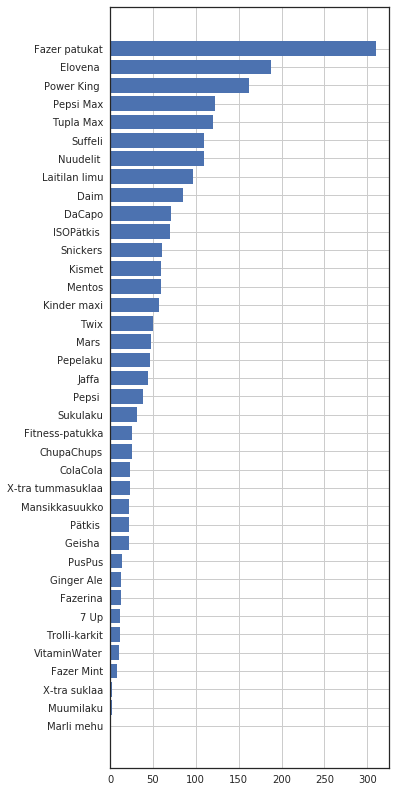

In [81]:
tuotteittainen = ostot.groupby("tuote").count().sort_values("id", ascending = True).reset_index()
plt.figure(1, (5, 14))
plt.barh(tuotteittainen.tuote, tuotteittainen.id)
plt.grid()
#plt.tight_layout()

## Päivittäiset kulutuksen vaihtelu vuoden sisällä

In [9]:
paivat = pd.DataFrame(columns=["date"], data=pd.date_range(start="2019-04-13", end="2020-04-12"))
paivittainen = paivat.merge(ostot, how="left", on="date").groupby("date").count().reset_index()

In [10]:
print("Keskiarvo: {:.2f}".format(paivittainen.tuote.mean()))
print("Keskihajonta: {:.2f}".format(paivittainen.tuote.std()))
print("Maksimi: {}".format(paivittainen.tuote.max()))
print("Minimi: {}".format(paivittainen.tuote.min()))

Keskiarvo: 5.98
Keskihajonta: 6.45
Maksimi: 32
Minimi: 0


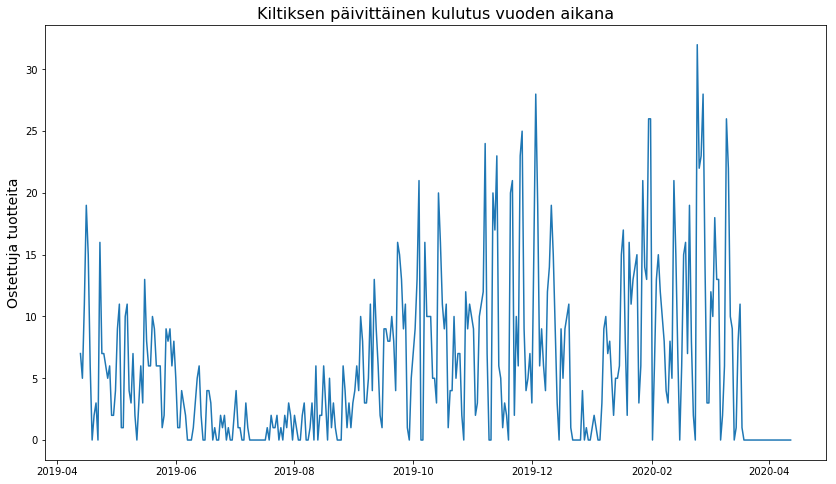

In [11]:
plt.figure(1, (14, 8))
plt.plot(paivittainen.date, paivittainen.tuote)
plt.title("Kiltiksen päivittäinen kulutus vuoden aikana", size=16)
plt.ylabel("Ostettuja tuotteita", size=14)
#plt.xticks(15 + np.arange(12) * 30, kuukaudet)
plt.show()

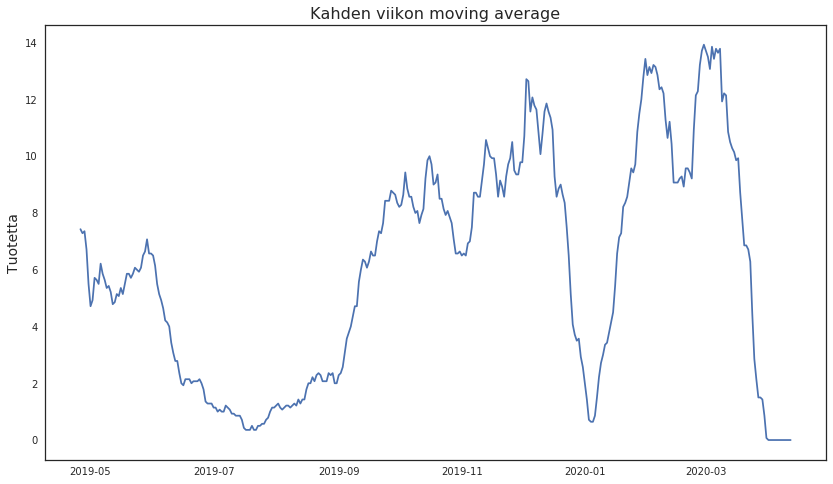

In [80]:
plt.figure(1, (14, 8))
plt.plot(paivittainen.date, paivittainen.tuote.rolling(14).mean())
plt.title("Kahden viikon moving average", size=16)
plt.ylabel("Tuotetta", size=14)
plt.show()

Maksimi 32 ostosta päivässä kirjattiin päivälle, jolloin järjestettiin myös killan vuoden 2020 vuosikokous.

## Kulutuksen vaihtelu viikon sisällä 

In [12]:
viikoittainen = ostot.groupby("weekday").count().reset_index()

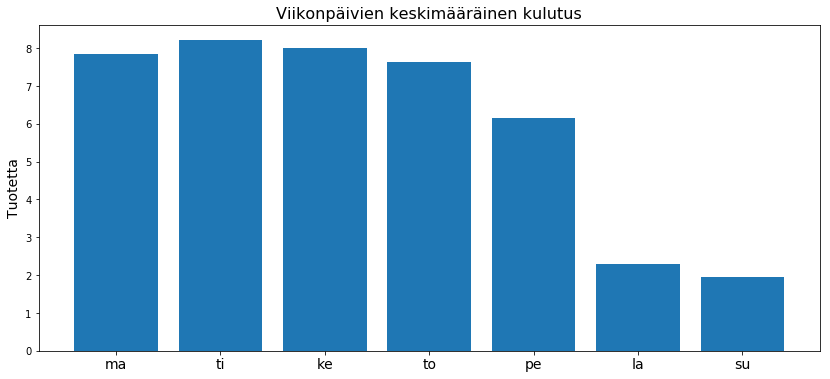

In [13]:
plt.figure(1, (14, 6))
plt.bar(np.arange(7), viikoittainen.tuote / 52)
plt.xticks(np.arange(7), ["ma", "ti", "ke", "to", "pe", "la", "su"], size=14)
plt.title("Viikonpäivien keskimääräinen kulutus", size=16)
plt.ylabel("Tuotetta", size=14)
plt.show()

## Viikoittaisen kulutuksen vaihtelu vuoden sisällä

In [14]:
weeks = pd.DataFrame(columns=["week"], data = 1 + (np.arange(0, 52) + 14) % 52)
viikot = weeks.merge(ostot, how="left", on="week").groupby("week").count().reset_index()

(0, 53)

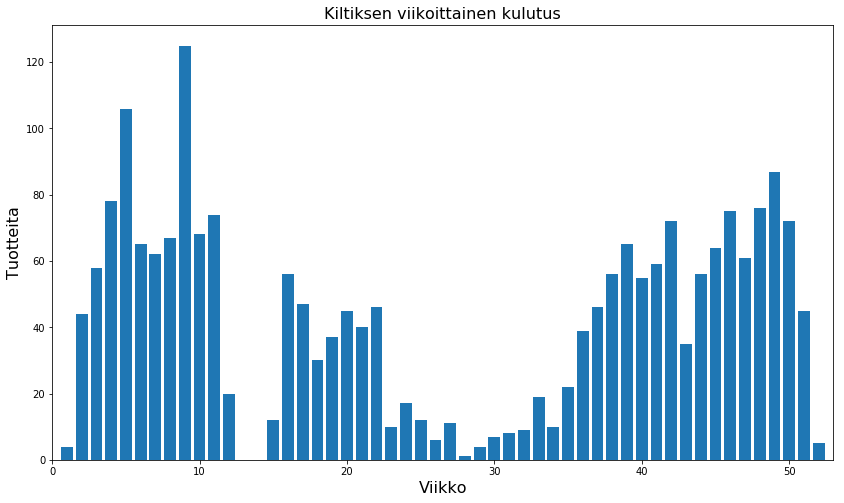

In [15]:
plt.figure(1, (14, 8))
plt.bar(viikot.week, viikot.tuote)
plt.title("Kiltiksen viikoittainen kulutus", size=16)
plt.ylabel("Tuotteita", size=16)
plt.xlabel("Viikko", size=16)
plt.xlim(0, 53)

## Minuutittainen tarkastelu

In [16]:
minuutittaiset = ostot.groupby("minute").count().reset_index()

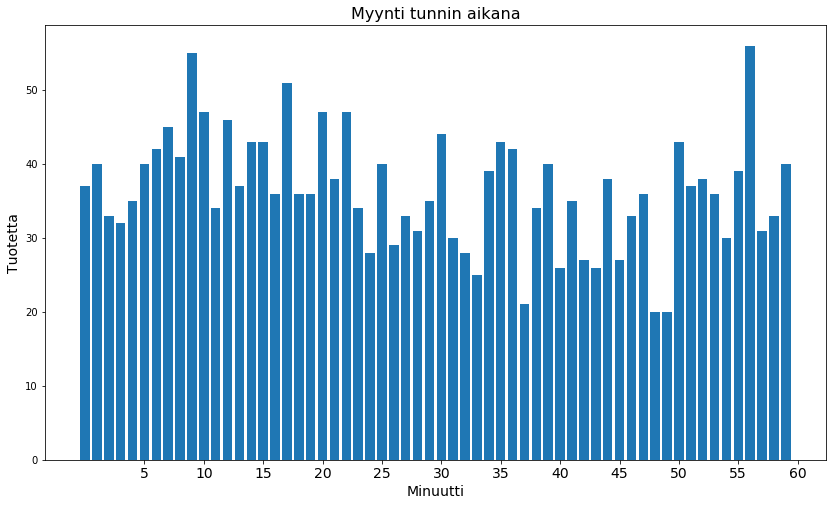

In [17]:
plt.figure(1, (14, 8))
plt.bar(minuutittaiset.minute, minuutittaiset.tuote)
plt.xticks(5 + np.arange(12) * 5, size=14)
plt.ylabel("Tuotetta", size=14)
plt.xlabel("Minuutti", size=14)
plt.title("Myynti tunnin aikana", size=16)
plt.show()

In [18]:
daily = ostot.hour * 60 + ostot.minute

In [20]:
x = np.linspace(0, 1440, 1000)
mu, std = norm.fit(daily)
p = norm.pdf(x, mu, std)

Text(0.5,0,'Minuutti')

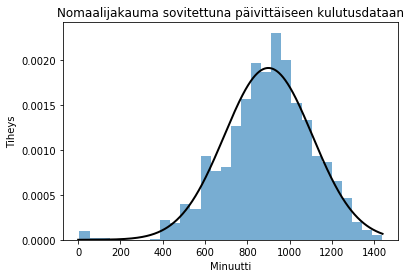

In [21]:
plt.hist(daily, density=True, bins=30, alpha=0.6)
plt.plot(x, p, linewidth=2, color="k")
plt.title("Nomaalijakauma sovitettuna päivittäiseen kulutusdataan")
plt.ylabel("Tiheys")
plt.xlabel("Minuutti")

In [24]:
tuotteet = list(set(data["tuote"]))
kayttajat = list(set(data["user"]))
m = np.zeros((len(tuotteet), len(kayttajat)))

In [25]:
def get_count(user, tuote):
    sql = """
    SELECT 
    COUNT(*)
    FROM transactions
    WHERE user = '{}'
    AND tuote = '{}'
    """.format(user, tuote)
    d = pd.read_sql(sql, conn)
    return d.iloc[0,0]

In [28]:
for i, t in enumerate(tuotteet):
    for j, k in enumerate(kayttajat):
        m[i, j] = get_count(k, t)

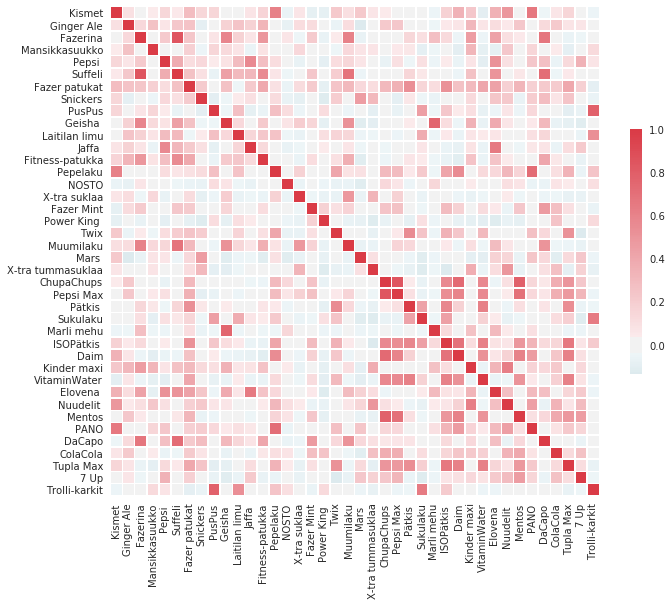

In [35]:
corr = np.corrcoef(m)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=tuotteet, yticklabels=tuotteet)